{'refrigerador': 0.38269507690101756, 'ventilador': 0.3473500980108471}


C:\Users\lenovo\AppData\Local\Temp\ipykernel_15604\1618237080.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4915480699512595' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'refrigerador'] = total_power * (device_powers['refrigerador'] / (device_powers['refrigerador'] + device_powers['ventilador']))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15604\1618237080.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0863049661873037' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'ventilador'] = total_power * (device_powers['ventilador'] / (device_powers['refrigerador'] + device_powers['ventilador']))


                fecha  Corriente_linea1  Predicted State  refrigerador  \
0 2024-09-25 15:00:01          0.937698                0      0.491548   
1 2024-09-25 15:00:01          0.937238                0      0.491307   
2 2024-09-25 15:00:02          0.937238                0      0.491307   
3 2024-09-25 15:00:03          0.938015                0      0.491714   
4 2024-09-25 15:00:04          0.937945                0      0.491678   

   ventilador  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  


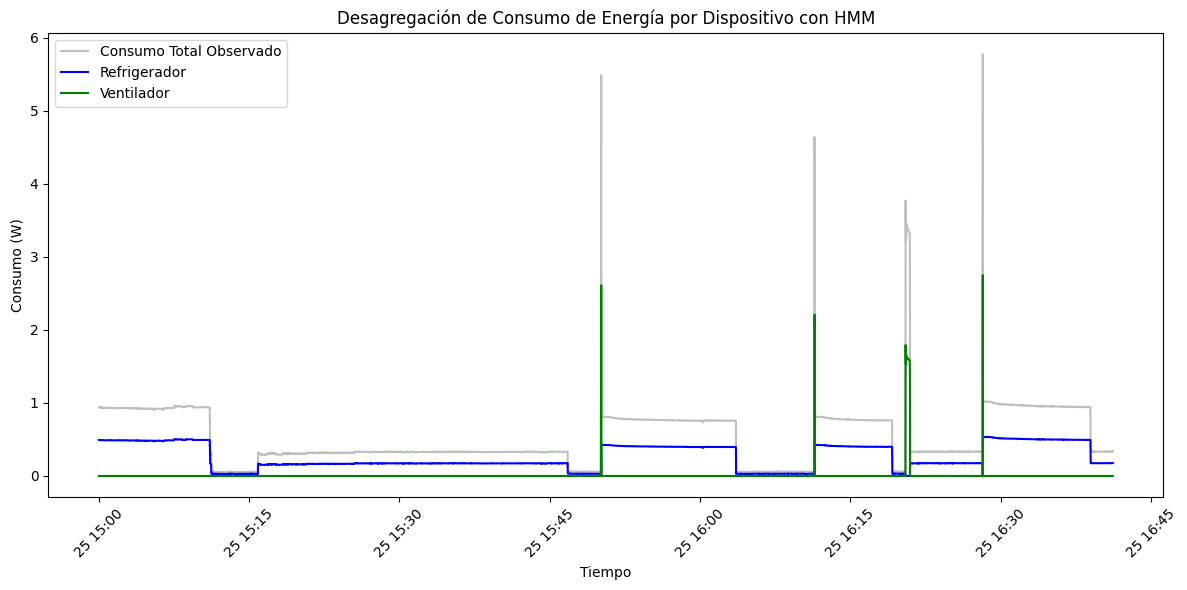

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Cargar los datos de consumo total
df = pd.read_csv('datos_generales.csv', parse_dates=['fecha'])
df_r = pd.read_csv('refrigerador.csv', parse_dates=['fecha'])
df_v = pd.read_csv('ventilador.csv', parse_dates=['fecha'])

# Supuestos de potencias promedio de cada dispositivo
device_powers = {
    'refrigerador': df_r['Corriente_R'].mean(),
    'ventilador': df_v['Corriente_V'].mean()
}

print(device_powers)

# Generar las observaciones (consumo total)
observations = df['Corriente_linea1'].values.reshape(-1, 1)

# Definir el número de dispositivos (estados ocultos)
n_devices = len(device_powers)

# Inicializar el modelo HMM
model = hmm.GaussianHMM(n_components=n_devices, covariance_type="diag", n_iter=100)

# Ajustar el modelo a las observaciones
model.fit(observations)

# Predecir los estados ocultos (dispositivos activos)
hidden_states = model.predict(observations)

# Crear un DataFrame para los estados ocultos
df['Predicted State'] = hidden_states

# Inicializar columnas para cada dispositivo
for device in device_powers.keys():
    df[device] = 0

# Desagregar el consumo total en función de los estados ocultos
for index, row in df.iterrows():
    total_power = row['Corriente_linea1']  # Consumo total en ese momento
    if row['Predicted State'] == 0:  # Refrigerador activo
        df.at[index, 'refrigerador'] = total_power * (device_powers['refrigerador'] / (device_powers['refrigerador'] + device_powers['ventilador']))
    elif row['Predicted State'] == 1:  # Ventilador activo
        df.at[index, 'ventilador'] = total_power * (device_powers['ventilador'] / (device_powers['refrigerador'] + device_powers['ventilador']))

# Mostrar las primeras filas del DataFrame con la desagregación
print(df.head())

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df['fecha'], df['Corriente_linea1'], label='Consumo Total Observado', color='gray', alpha=0.5)
plt.plot(df['fecha'], df['refrigerador'], label='Refrigerador', color='blue')
plt.plot(df['fecha'], df['ventilador'], label='Ventilador', color='green')
plt.title('Desagregación de Consumo de Energía por Dispositivo con HMM')
plt.xlabel('Tiempo')
plt.ylabel('Consumo (W)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()